In [1]:
import os
import pickle
import shutil
import pandas as pd
import numpy as np
from scipy.stats import mode
from scipy.signal import decimate


In [2]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_SUBPATH = '/data'
DATASET_PATH = MAIN_PATH + DATA_SUBPATH + '/unzip/WESAD'
UNPROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/unprocessed/WESAD'

In [3]:
TARGET_RATE = 4
ORIGINAL_LABEL_RATE = 700

In [4]:
minfolder = 2
maxfolder = 18
folders = [f'S{i}' for i in range(minfolder, maxfolder)]
print(folders)

['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17']


This process unpacking the zip files can take up to 3 minutes. Depending on the computational power available.

In [5]:
shutil.unpack_archive(MAIN_PATH + DATA_SUBPATH + '/WESAD.zip', MAIN_PATH + DATA_SUBPATH + '/unzip')

In [6]:
data_folders = []
for subfolder in folders:
    data_folders.append(f"{MAIN_PATH}{DATA_SUBPATH}/unzip/WESAD/{subfolder}/{subfolder}_E4_Data.zip")
print(data_folders)

['d:\\Master of Applied IT/data/unzip/WESAD/S2/S2_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S3/S3_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S4/S4_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S5/S5_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S6/S6_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S7/S7_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S8/S8_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S9/S9_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S10/S10_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S11/S11_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S12/S12_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S13/S13_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S14/S14_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S15/S15_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S16/S16_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WES

In [7]:
for folder, data_folder in zip(folders, data_folders):
    try:
        shutil.unpack_archive(data_folder, os.path.join(UNPROCESSED_PATH, f'{folder}'))
        print("Preparing folder:", folder)
    except shutil.ReadError:
        print(f"Skipping {data_folder} as it is not a zip file or missing.")

print("Finished unzipping and preparing files.")

Preparing folder: S2
Preparing folder: S3
Preparing folder: S4
Preparing folder: S5
Preparing folder: S6
Preparing folder: S7
Preparing folder: S8
Preparing folder: S9
Preparing folder: S10
Preparing folder: S11
Skipping d:\Master of Applied IT/data/unzip/WESAD/S12/S12_E4_Data.zip as it is not a zip file or missing.
Preparing folder: S13
Preparing folder: S14
Preparing folder: S15
Preparing folder: S16
Preparing folder: S17
Finished unzipping and preparing files.


In [8]:
def create_destination_folder(destination_folder, folder):
    """Create the destination folder if it doesn't exist."""
    destination_path = os.path.join(destination_folder, folder)
    os.makedirs(destination_path, exist_ok=True)
    return destination_path

def downsample_signal_with_filter(signal, original_rate, target_rate):
    """Downsample a signal with anti-aliasing filter using scipy's decimate."""
    decimation_factor = original_rate // target_rate
    if decimation_factor > 1:
        return decimate(signal, decimation_factor, zero_phase=True)
    return signal

def downsample_labels(labels, original_rate, target_rate):
    """Downsample labels using mode filtering."""
    decimation_factor = original_rate // target_rate
    downsampled_labels = []
    for i in range(0, len(labels), decimation_factor):
        segment = labels[i:i + decimation_factor]
        mode_value, _ = mode(segment)
        downsampled_labels.append(mode_value)  # mode returns a 1D array
    return np.array(downsampled_labels)

In [9]:
original_acc_rate = 32
original_bvp_rate = 64

def process_wrist_signals(folder):
    """Process wrist signals and save them."""
    destination_path = create_destination_folder(UNPROCESSED_PATH , folder +'/wrist')
    
    # Open the pickle file
    source_path = os.path.join(DATASET_PATH, folder, f'{folder}.pkl')
    if not os.path.exists(source_path):
        print(f"Skipping {source_path} as it does not exist.")
        return
    
    with open(source_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
        
        # Extract wrist signals
        signals = data['signal']['wrist']
        w_x = signals['ACC'][:, 0]          
        w_y = signals['ACC'][:, 1]          
        w_z = signals['ACC'][:, 2]          
        w_bvp = signals['BVP'][:, 0]  
        w_eda = signals['EDA'][:, 0]   
        w_temp = signals['TEMP'][:, 0]    
        labels = data['label']

                # Downsample labels from 700 Hz to 4 Hz
        downsampled_labels = downsample_labels(labels, 700, TARGET_RATE)

        # Downsample the wrist signals where necessary
        w_x_resampled = downsample_signal_with_filter(w_x, original_acc_rate, TARGET_RATE)
        w_y_resampled = downsample_signal_with_filter(w_y, original_acc_rate, TARGET_RATE)
        w_z_resampled = downsample_signal_with_filter(w_z, original_acc_rate, TARGET_RATE)
        w_bvp_resampled = downsample_signal_with_filter(w_bvp, original_bvp_rate, TARGET_RATE)

        print(f"Processed wrist signals for: {folder}")

        # Create DataFrame with all wrist signals
        wrist_signals = np.array([w_x_resampled, w_y_resampled, w_z_resampled, w_bvp_resampled, w_eda, w_temp, downsampled_labels]).T
        df_wrist = pd.DataFrame(data=wrist_signals, columns=["X", "Y", "Z", "BVP", "EDA", "TEMP", "labels"]) 
        df_wrist['ID'] = folder
        df_wrist['Time'] = np.arange(len(downsampled_labels)) / TARGET_RATE
        df_wrist['labels'] = df_wrist['labels'].replace([5, 6, 7], 0)

        # Save the DataFrame as a CSV file
        csv_path_wrist = os.path.join(destination_path, f'{folder}.csv')
        df_wrist.to_csv(csv_path_wrist, index=False)
        print(f"Saved wrist data: {csv_path_wrist}")

In [11]:
def process_chest_signals(folder):
    """Process chest signals and save them."""
    destination_path = create_destination_folder(UNPROCESSED_PATH , folder +'/chest')
    
    # Open the pickle file
    source_path = os.path.join(DATASET_PATH, folder, f'{folder}.pkl')
    if not os.path.exists(source_path):
        print(f"Skipping {source_path} as it does not exist.")
        return
    
    with open(source_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
        
        # Extract chest signals
        signals = data['signal']['chest']
        c_ecg = signals['ECG'][:, 0]     
        c_eda = signals['EDA'][:, 0]     
        c_emg = signals['EMG'][:, 0]     
        c_temp = signals['Temp'][:, 0]   
        c_resp = signals['Resp'][:, 0]   
        c_x = signals['ACC'][:, 0]       
        c_y = signals['ACC'][:, 1]       
        c_z = signals['ACC'][:, 2]       
        labels = data['label']           
        
        # Create DataFrame with all chest signals
        chest_signals = np.array([c_ecg, c_eda, c_emg, c_temp, c_resp, c_x, c_y, c_z, labels]).T
        df_chest = pd.DataFrame(data=chest_signals, columns=["ECG", "EDA", "EMG", "TEMP", "RESP", "X", "Y", "Z", "labels"]) 
        df_chest['ID'] = folder
        df_chest['Time'] = np.arange(len(labels)) / 700
        df_chest['labels'] = df_chest['labels'].replace([5, 6, 7], 0)
        
        # Save the DataFrame as a CSV file
        csv_path_chest = os.path.join(destination_path, f'{folder}.csv')
        df_chest.to_csv(csv_path_chest, index=False)
        print(f"Saved chest data: {csv_path_chest}")

In [12]:
# Iterate over the folders and process wrist and chest signals
for folder in folders:
    process_wrist_signals(folder)
    process_chest_signals(folder)

Processed wrist signals for: S2
Saved wrist data: d:\Master of Applied IT/data/unprocessed/WESAD\S2/wrist\S2.csv
Saved chest data: d:\Master of Applied IT/data/unprocessed/WESAD\S2/chest\S2.csv
Processed wrist signals for: S3
Saved wrist data: d:\Master of Applied IT/data/unprocessed/WESAD\S3/wrist\S3.csv
Saved chest data: d:\Master of Applied IT/data/unprocessed/WESAD\S3/chest\S3.csv
Processed wrist signals for: S4
Saved wrist data: d:\Master of Applied IT/data/unprocessed/WESAD\S4/wrist\S4.csv
Saved chest data: d:\Master of Applied IT/data/unprocessed/WESAD\S4/chest\S4.csv
Processed wrist signals for: S5
Saved wrist data: d:\Master of Applied IT/data/unprocessed/WESAD\S5/wrist\S5.csv
Saved chest data: d:\Master of Applied IT/data/unprocessed/WESAD\S5/chest\S5.csv
Processed wrist signals for: S6
Saved wrist data: d:\Master of Applied IT/data/unprocessed/WESAD\S6/wrist\S6.csv
Saved chest data: d:\Master of Applied IT/data/unprocessed/WESAD\S6/chest\S6.csv
Processed wrist signals for: S

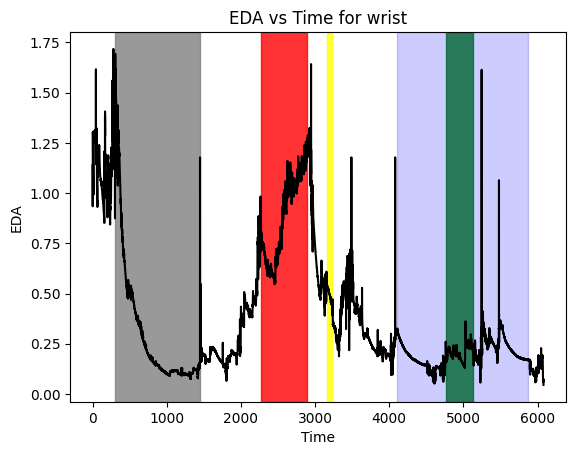

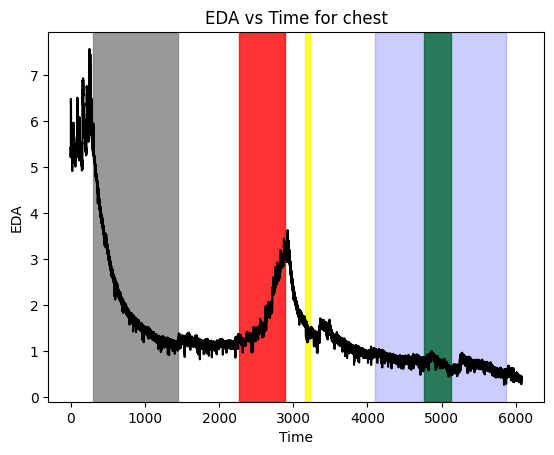

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
def plot_eda_with_labels(data_paths):
    for data_path in data_paths:
        # Read the CSV file
        df = pd.read_csv(data_path)

        # Extract the columns
        w_eda = df['EDA']
        labels = df['labels']

        # Calculate the time values
        time = df['Time']

        # Create a color map for different label values
        label_colors = {0: 'white', 1: 'grey', 2: 'red', 3: 'green', 4: 'blue', 5: 'yellow', 6: 'yellow'}

        # Plot the data
        for label_value, color in label_colors.items():
            indices = labels.index[labels == label_value].tolist()
            if indices:
                start = time[indices[0]]
                end = time[indices[-1]]
                alpha = 0.2 if label_value == 4 else 0.8  # Adjust alpha based on label value
                plt.axvspan(start, end, color=color, alpha=alpha)

        plt.plot(time, w_eda, color='black')  # Plot the data on top

        plt.xlabel('Time')
        plt.ylabel('EDA')
        plt.title(f'EDA vs Time for {data_path.split("/")[-2]}')
        plt.show()

# Example usage
wrist_data_path = MAIN_PATH + '/data/unprocessed/WESAD/S2/wrist/S2.csv'
chest_data_path = MAIN_PATH + '/data/unprocessed/WESAD/S2/chest/S2.csv'
plot_eda_with_labels([wrist_data_path, chest_data_path])


In [142]:
# Create empty DataFrames to store the merged wrist and chest data
merged_wrist_df = pd.DataFrame()
merged_chest_df = pd.DataFrame()

# Loop through the folders and merge the wrist and chest CSV files
for folder in folders:
    wrist_file_path = os.path.join(UNPROCESSED_PATH, folder, 'wrist', f'{folder}.csv')
    chest_file_path = os.path.join(UNPROCESSED_PATH, folder, 'chest', f'{folder}.csv')
    
    if os.path.exists(wrist_file_path):
        wrist_df = pd.read_csv(wrist_file_path)
        merged_wrist_df = pd.concat([merged_wrist_df, wrist_df], ignore_index=True)
    else:
        print("Wrist file does not exist:", wrist_file_path)
    
    if os.path.exists(chest_file_path):
        chest_df = pd.read_csv(chest_file_path)
        merged_chest_df = pd.concat([merged_chest_df, chest_df], ignore_index=True)
    else:
        print("Chest file does not exist:", chest_file_path)

# Save the merged wrist DataFrame as a CSV file
merged_wrist_file_path = os.path.join(MAIN_PATH + DATA_SUBPATH, 'wrist_merged_data.csv')
merged_wrist_df.to_csv(merged_wrist_file_path, index=False)
print("Merged wrist data saved as:", merged_wrist_file_path)

# Save the merged chest DataFrame as a CSV file
merged_chest_file_path = os.path.join(MAIN_PATH + DATA_SUBPATH, 'chest_merged_data.csv')
merged_chest_df.to_csv(merged_chest_file_path, index=False)
print("Merged chest data saved as:", merged_chest_file_path)


Wrist file does not exist: d:\Master of Applied IT/data/unprocessed/WESAD\S12\wrist\S12.csv
Chest file does not exist: d:\Master of Applied IT/data/unprocessed/WESAD\S12\chest\S12.csv
Merged wrist data saved as: d:\Master of Applied IT/data\wrist_merged_data.csv


KeyboardInterrupt: 